In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# 📦 Imports
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm


# 🧠 Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Using: cpu


In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# 🧾 Custom Dataset class using OpenCV
class BreastCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.img_paths = []
        self.labels = []
        self.transform = transform

        print(f"📂 Indexing images in {root_dir}...")
        for label in ['0', '1']:
            class_dir = os.path.join(root_dir, label)
            files = os.listdir(class_dir)
            for fname in tqdm(files, desc=f"Label {label}", leave=False):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.img_paths.append(os.path.join(class_dir, fname))
                    self.labels.append(int(label))
        print(f"✅ Loaded {len(self.img_paths)} images.")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# 🎨 Image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [4]:
# 📁 Dataset paths
base_dir = "/kaggle/input/breast-cancer-detection"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir  = os.path.join(base_dir, "test")

In [5]:
# Count images in each class per split
def count_images(base_path):
    records = []
    for split in ['train', 'valid', 'test']:
        for label in ['0', '1']:
            folder = os.path.join(base_path, split, label)
            count = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            records.append({'Split': split, 'Label': int(label), 'Count': count})
    return pd.DataFrame(records)

df_counts = count_images(base_dir)
print(df_counts)



   Split  Label  Count
0  train      0   1569
1  train      1    803
2  valid      0    448
3  valid      1    227
4   test      0    208
5   test      1    128


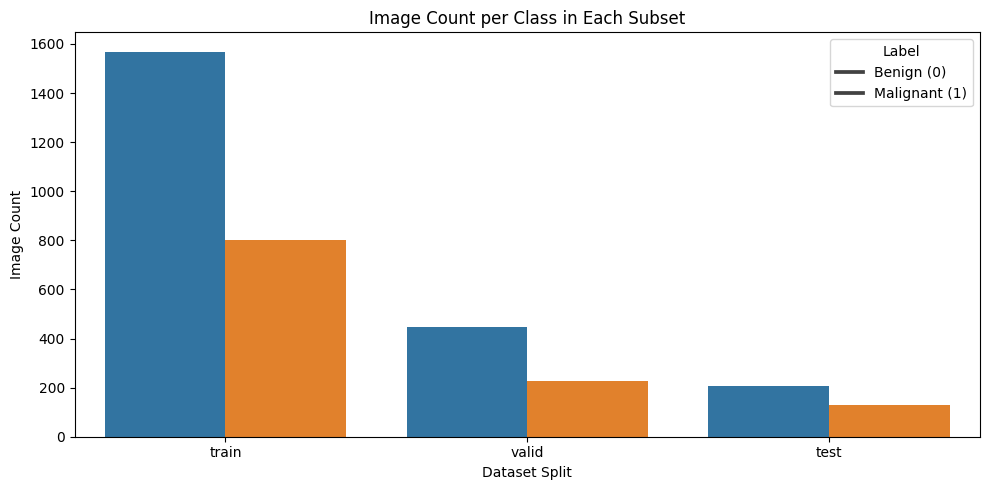

In [6]:
# 📈 Plot distribution
plt.figure(figsize=(10, 5))
sns.barplot(data=df_counts, x="Split", y="Count", hue="Label")
plt.title("Image Count per Class in Each Subset")
plt.xlabel("Dataset Split")
plt.ylabel("Image Count")
plt.legend(title="Label", labels=["Benign (0)", "Malignant (1)"])
plt.tight_layout()
plt.show()

# 🖼 Preview images from each class
def show_images(split, label, n=5):
    folder = os.path.join(base_dir, split, str(label))
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))][:n]
    plt.figure(figsize=(15, 3))
    for i, fname in enumerate(files):
        img = cv2.imread(os.path.join(folder, fname))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f"Label {label}")
        plt.axis("off")
    plt.suptitle(f"Sample Images from {split}/ Class {label}")
    plt.tight_layout()
    plt.show()

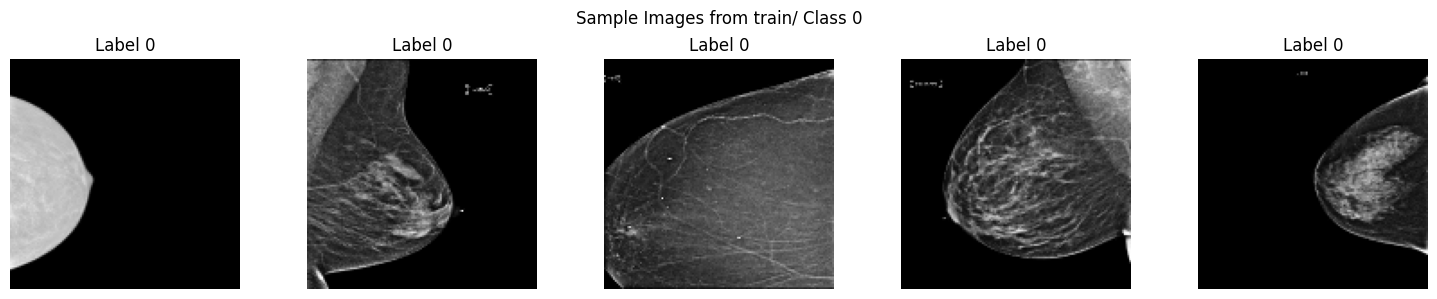

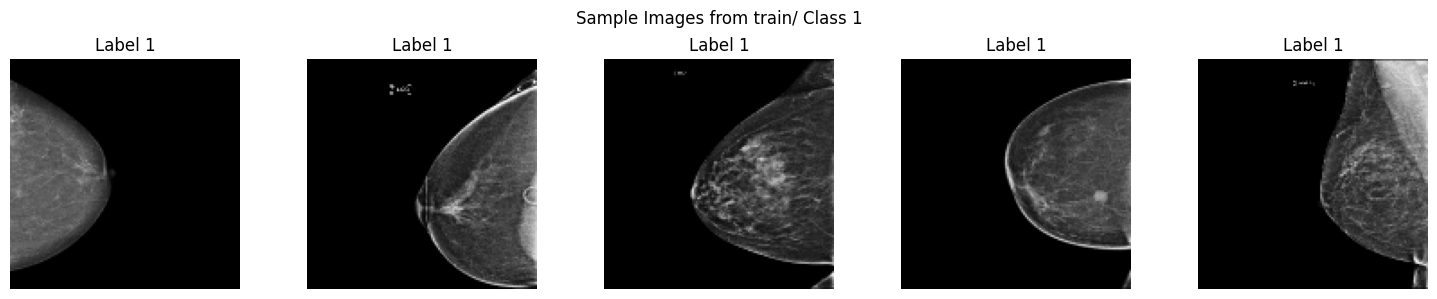

In [7]:
# 🔍 Display train/0 and train/1 sample images
show_images('train', 0)
show_images('train', 1)

In [8]:
# 📂 Load datasets
train_dataset = BreastCancerDataset(train_dir, transform=transform)
valid_dataset = BreastCancerDataset(valid_dir, transform=transform)
test_dataset  = BreastCancerDataset(test_dir,  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

📂 Indexing images in /kaggle/input/breast-cancer-detection/train...


Label 0:   0%|          | 0/1569 [00:00<?, ?it/s]

Label 1:   0%|          | 0/803 [00:00<?, ?it/s]

✅ Loaded 2372 images.
📂 Indexing images in /kaggle/input/breast-cancer-detection/valid...


Label 0:   0%|          | 0/448 [00:00<?, ?it/s]

Label 1:   0%|          | 0/227 [00:00<?, ?it/s]

✅ Loaded 675 images.
📂 Indexing images in /kaggle/input/breast-cancer-detection/test...


Label 0:   0%|          | 0/208 [00:00<?, ?it/s]

Label 1:   0%|          | 0/128 [00:00<?, ?it/s]

✅ Loaded 336 images.


In [9]:
# 🧠 Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 128 → 64
        x = self.pool(F.relu(self.conv2(x)))  # 64 → 32
        x = x.view(-1, 32 * 32 * 32)          # Flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ⚙️ Instantiate model, loss, optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
# 🔁 Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=total_loss / (loop.n + 1))
    
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/10:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.7160


Epoch 2/10:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2 | Loss: 0.6408


Epoch 3/10:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3 | Loss: 0.6317


Epoch 4/10:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4 | Loss: 0.6199


Epoch 5/10:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 5 | Loss: 0.5988


Epoch 6/10:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 6 | Loss: 0.5674


Epoch 7/10:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 7 | Loss: 0.5227


Epoch 8/10:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 8 | Loss: 0.4476


Epoch 9/10:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 9 | Loss: 0.3653


Epoch 10/10:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.2788


In [11]:
# 📊 Evaluation function
def evaluate(loader, name="Dataset"):
    model.eval()
    all_preds, all_labels = [], []
    loop = tqdm(loader, desc=f"Evaluating {name}")
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(f"\n📈 {name} Report:")
    print(classification_report(all_labels, all_preds))

In [12]:
# ✅ Evaluate on validation and test sets
evaluate(valid_loader, "Validation")
evaluate(test_loader, "Test")

Evaluating Validation:   0%|          | 0/22 [00:00<?, ?it/s]


📈 Validation Report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       448
           1       0.45      0.40      0.43       227

    accuracy                           0.64       675
   macro avg       0.58      0.58      0.58       675
weighted avg       0.63      0.64      0.63       675



Evaluating Test:   0%|          | 0/11 [00:00<?, ?it/s]


📈 Test Report:
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       208
           1       0.46      0.30      0.37       128

    accuracy                           0.60       336
   macro avg       0.56      0.54      0.54       336
weighted avg       0.58      0.60      0.58       336

